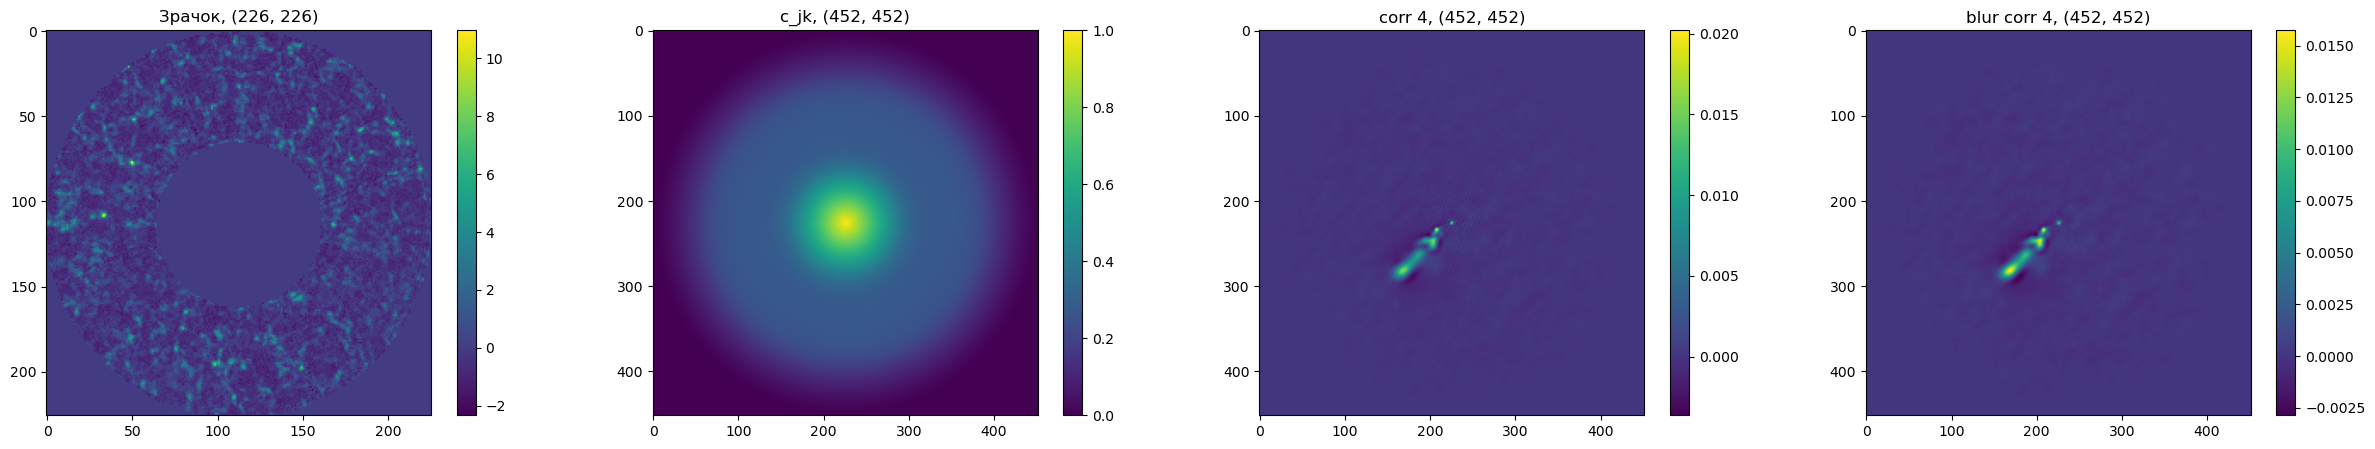

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import shift
from scipy.optimize import curve_fit
from skimage.filters import threshold_multiotsu, threshold_otsu, median

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
    if idx == (len(array) - 1):
        return idx, idx-1
    if idx == 0:
        return 1, 0
    else:
        if array[idx] > value:
            return idx, idx-1 
        if array[idx] < value:
            return idx+1, idx

def gamma_poly_se(X, Y, Vx, Vy, Cn2, z): 
    global cjk, t, a1, gammas, delta
    
    Cn2=Cn2*1e-14
    z=z*1000

    # мб дать как то обозначить приоритетность выбора? или че нибудь такое. или шаг типа сделать равнозначный как по
#     высоте, так и по мощности
    
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
    
    lv = find_nearest(a1, z)[1]
    uv = find_nearest(a1, z)[0]
    
    res = gammas[lv] + (z - a1[lv])*((gammas[uv] - gammas[lv])/(a1[uv] - a1[lv]))
    
    res = (res/(1e-13))*Cn2
    res = shift(res, (-Ypix, Xpix), order=1)  

    res = res * cjk
    return res

# ----------- входные параметры
D = 2.5
latency = 4
data_dir = 'D:/astro/domecam'
gammas_type = 'blur'
lambda_=500*pow(10, -9) # нм


sec_per_frame = 0.01
t = sec_per_frame * latency
k = 2*np.pi/lambda_

# ---------- считывание зрачка, картины мерцаний, автокорреляции зрачка и гамм

if gammas_type == 'orig':
    data = np.loadtxt(f'{data_dir}/corr{latency}_orig.gz')
    gammas = np.load(f'{data_dir}/gammas_orig.npy')

if gammas_type == 'blur':
    data = np.loadtxt(f'{data_dir}/corr{latency}_blur.gz')
    gammas = np.load(f'{data_dir}/gammas_blur.npy')

pupil = np.loadtxt(f'{data_dir}/frame.gz')
cjk = np.loadtxt(f'{data_dir}/cjk.gz')
a1 = np.loadtxt(f'{data_dir}/z.gz')

# ------------ шаг для функции гамма
x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
X, Y = np.meshgrid(x, y)

delta = D/(pupil.shape[0]) # шаг по пикселю

# ------------------ распределение гамм


fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))

fig.colorbar(ax.imshow(pupil), ax = ax)
ax.grid(False)
ax.set_title(f'Зрачок, {pupil.shape}')

fig.colorbar(ax2.imshow(cjk), ax=ax2)
ax2.grid(False)
ax2.set_title(f'c_jk, {cjk.shape}')

fig.colorbar(ax3.imshow(np.loadtxt(f'{data_dir}/corr{latency}_orig.gz')), ax=ax3)
ax3.grid(False)
ax3.set_title(f'corr 4, {data.shape}')

fig.colorbar(ax4.imshow(np.loadtxt(f'{data_dir}/corr{latency}_blur.gz')), ax=ax4)
ax4.grid(False)
ax4.set_title(f'blur corr 4, {data.shape}')

def CLEAN(dirty, gain=None, thresh=None, niter=None, window=None):
    global t, delta
    st = time.perf_counter()
    comps = np.zeros(dirty.shape)
    res = np.array(dirty) 
    cl = np.zeros(dirty.shape)
    
    k = 5
    res2 = np.array(dirty)
    cl2 = np.zeros(dirty.shape)

    tmp = 0
    tmp_Vx = []
    tmp_Vy = []
    all_params = []
    for i in range(niter):
        my, mx = np.unravel_index(np.argmax(res), res.shape)
        mval=res[my, mx]*gain
        comps[my, mx]+=mval
        
        Vy = (dirty.shape[0]//2-my)*delta/t
        Vx = -(dirty.shape[1]//2-mx)*delta/t
        
        tmp_Vx.append(Vx)
        tmp_Vy.append(Vy)
                
        if i > 5\
        and tmp_Vx[i-4] == tmp_Vx[i] and tmp_Vx[i-3] == tmp_Vx[i] and tmp_Vx[i-2] == tmp_Vx[i] and tmp_Vx[i-1] == tmp_Vx[i]\
        and tmp_Vy[i-4] == tmp_Vy[i] and tmp_Vy[i-3] == tmp_Vy[i] and tmp_Vy[i-2] == tmp_Vy[i] and tmp_Vy[i-1] == tmp_Vy[i]:
            all_params = np.array(all_params)
            all_params = all_params[:-4, :]
            print('Stucked')
            break
        
        if int(Vx) == 0 and int(Vy) == 0:
            print('\nDome turbulence')
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 2))) * 10
            myParams = [0, 0, p0_Cn2, 2]
            psf, params = multi_speckle_fit(myParams, ydata=res, window=window//2)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*0.99
        else:
            p0_Cn2 = (res[my, mx]/np.max(gamma_poly_se(X, Y, Vx, Vy, 10, 15))) * 10
            myParams = [Vx, Vy, p0_Cn2, (15+5*np.sin(np.random.uniform(-np.pi, np.pi)))]  
            psf, params = multi_speckle_fit(myParams, ydata=res, window=window)
            print('test Cn2:', p0_Cn2)
            print('-initial value:', res[my, mx])
            res -= psf*gain
        
        cl += psf*gain
        all_params.append(params)
        print('-residual value:', res[my, mx])
        
        if (i+1)%k == 0:
            print('\nCheckpoint fitting...')
#             fit, params2 = one_speckle_fit(all_params[i-(k-1):i+1], res2)
#             res2 -= fit
#             cl2 += fit
            
#             plt.figure()
#             plt.imshow(res2)
#             plt.show()
            
#             plt.figure()
#             plt.imshow(cl2)
#             plt.show()
        print(' ')
        
        tmp = i
        if np.max(res) < thresh:
            print('Thresh reached!')
            break
    print('Total iterations:', tmp+1)
    print('time:', time.perf_counter()-st)
    return comps, res, cl, np.array(all_params)


def multi_speckle_fit(params, ydata=None, window=None):
    global t, delta
    st=time.perf_counter()  
    def speckle_fit(params, ydata, window=None):
        k=window
        def _g(one_dim_x, *args): 
            arr = np.zeros(one_dim_x[0].shape)
            Vx = args[0]
            Vy = args[1]
            Cn2 = args[2]
            z = args[3]
            arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z)[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k].ravel()
#             arr += gamma_poly_se(one_dim_x[0], one_dim_x[1], Vx, Vy, Cn2, z).ravel()
            return arr
        
        xcoord = params[0]
        ycoord = params[1]
        cr = ydata.shape[0]//2, ydata.shape[1]//2
        
        Xpix1 = int(xcoord*t/delta) + cr[1]
        Ypix1 = -int(ycoord*t/delta) + cr[0]
        
        fit = np.zeros(ydata.shape)
        ydata = ydata[Ypix1-k:Ypix1+k, Xpix1-k:Xpix1+k]
        
        plt.figure()
        plt.imshow(ydata)
        plt.colorbar()
        plt.show()
        
        x = np.linspace(-ydata.shape[1]//2, ydata.shape[1]//2-1, ydata.shape[1])
        y = np.linspace(-ydata.shape[0]//2, ydata.shape[0]//2-1, ydata.shape[0])
        X, Y = np.meshgrid(x, y)
        
        xdata = np.vstack((X.ravel(), Y.ravel()))
        
        ydata = ydata.ravel()

        bounds = [[-np.inf, -np.inf, 0, 0], [np.inf, np.inf, np.inf, np.inf]]
#         bounds = [[-np.inf, -np.inf, params[2]-0.01, 0], [np.inf, np.inf, params[2]+0.01, np.inf]]
        popt, pcov = curve_fit(_g, xdata, ydata, p0=params, bounds=bounds)
        
        fit += gamma_poly_se(X, Y, *popt)        

        return fit, popt[0], popt[1], popt[2], popt[3]
        
    res = np.zeros(data.shape)
    print(f'Speckle fitting: {params[0]} {params[1]} {1e-14*params[2]} {1000*params[3]}')
    fit, Vx, Vy, Cn2, z = speckle_fit(params, ydata, window=window)
    
    xcoord = int(Vx*t/delta)
    ycoord = int(Vy*t/delta)
    res +=fit        
    print(f'Fitted parametrs: {Vx:.2f} {Vy:.2f} {1e-14*Cn2} {1000*z}')
    print('time:', time.perf_counter()-st)    
    return res, [Vx, Vy, Cn2, z]

def one_speckle_fit(params=None, data=None): 
    def _g(M, *args): 
        x, y = M
        arr = np.zeros(x.shape)
        for i in range(len(args)//4):
            arr += gamma_poly_se(x, y, *args[i*4:i*4+4]).ravel()
        return arr
        
    p0 = [p for prms in params for p in prms]
        
    st=time.perf_counter()
       
    x = np.linspace(-data.shape[1]//2, data.shape[1]//2-1, data.shape[1])
    y = np.linspace(-data.shape[0]//2, data.shape[0]//2-1, data.shape[0])
    X, Y = np.meshgrid(x, y)

    fit = np.zeros(X.shape) 
    xdata = np.vstack((X.ravel(), Y.ravel())) 
    ydata = data.ravel()
        
    lb = [-np.inf, -np.inf, 0, 0]
    lb = np.tile(lb, len(p0)//4)
    ub = [np.inf, np.inf, np.inf, np.inf]
    ub = np.tile(ub, len(p0)//4)
        
    popt, pcov = curve_fit(_g, xdata, ydata, p0, bounds=[lb, ub])

    for i in range(len(popt)//4):
        fit += gamma_poly_se(X, Y, *popt[i*4:i*4+4])

    print(f'Time: {time.perf_counter()-st:.4f}')

    for i in range(len(popt)//4):
        print(*popt[i*4:i*4+4])

    return fit, popt

Speckle fitting: -13.550884955752212 -13.27433628318584 5.040638235148105e-14 11303.710942920992


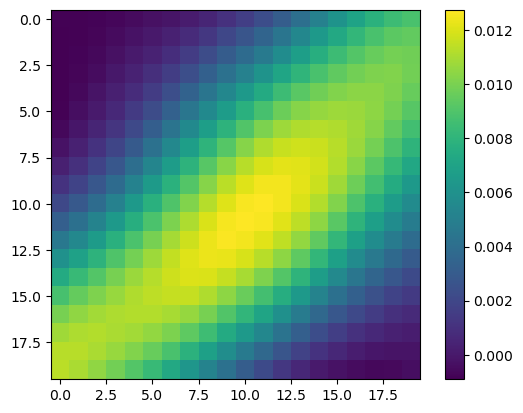

Fitted parametrs: -13.54 -13.34 1.0304773307327921e-14 80240.26599601527
time: 0.5615384000000176
test Cn2: 5.040638235148105
-initial value: 0.0127582926196525
-residual value: 0.0011662050118130107
 
Speckle fitting: -17.422566371681416 -16.039823008849556 5.3092146334630356e-14 19243.872437464193


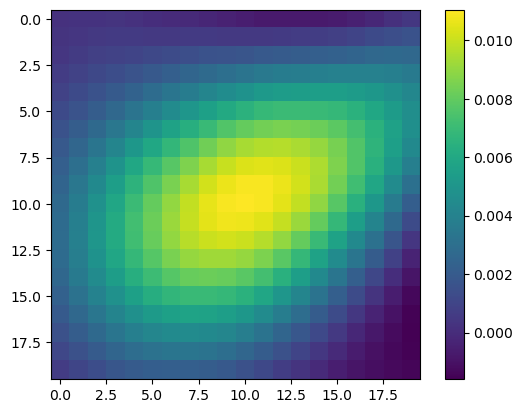

Fitted parametrs: -17.57 -16.04 2.3594580081376407e-14 38407.45718831668
time: 0.7067582000000243
test Cn2: 5.309214633463036
-initial value: 0.011044531140825157
-residual value: -0.00024034618122873927
 
Speckle fitting: -10.508849557522124 -10.232300884955752 2.3744576895111544e-14 12822.802828744238


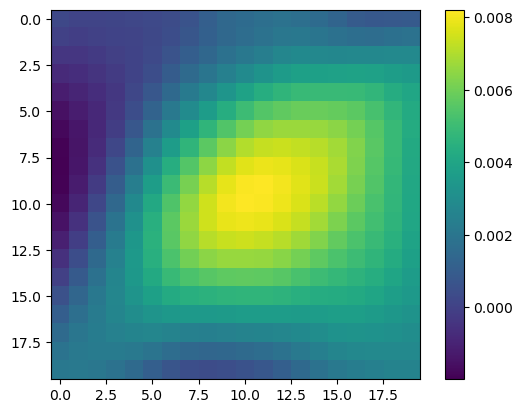

Fitted parametrs: -9.96 -10.32 8.97351305985689e-15 44409.99786413633
time: 0.5115030999999703
test Cn2: 2.3744576895111544
-initial value: 0.00820545378178275
-residual value: 0.0006259676124016379
 
Speckle fitting: -5.530973451327434 -6.63716814159292 1.3903658460273738e-14 15572.093701901804


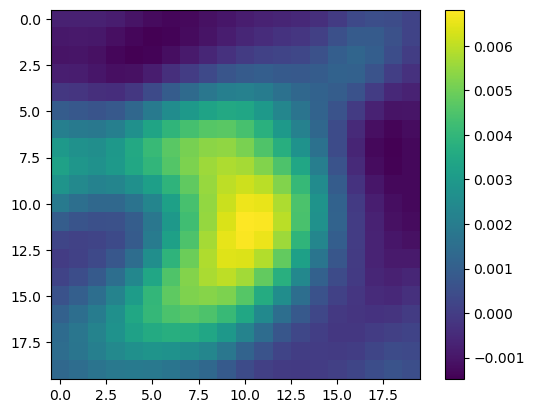

Fitted parametrs: -5.99 -6.70 8.987159481072338e-15 24205.814036358497
time: 0.4067794000000049
test Cn2: 1.3903658460273738
-initial value: 0.006811424627464108
-residual value: 0.0006198711264161633
 
Speckle fitting: -9.679203539823009 -6.084070796460177 1.0425349779265669e-14 19124.6037850568


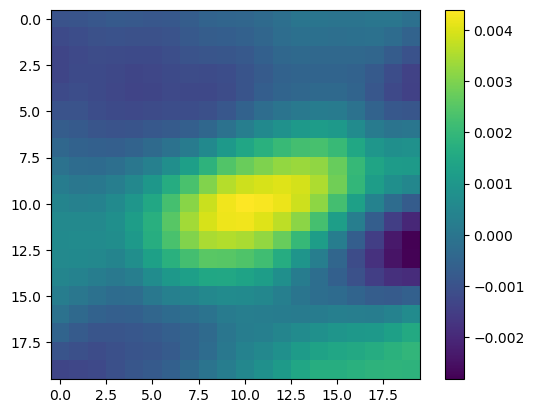

Fitted parametrs: -9.61 -6.17 1.515946359034574e-14 10469.40544597083
time: 0.5033348000000046
test Cn2: 1.042534977926567
-initial value: 0.004398358396288583
-residual value: -1.0429955859536655e-06

Checkpoint fitting...
 
Speckle fitting: -14.657079646017698 -14.380530973451327 1.5975387881184423e-14 16963.155448337624


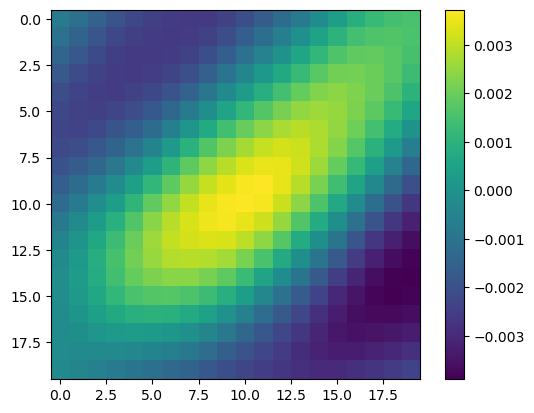

Fitted parametrs: -14.84 -14.38 2.7060076179256488e-14 11111.107102768769
time: 1.169744900000012
test Cn2: 1.5975387881184424
-initial value: 0.003729357047092695
-residual value: -0.0008601444387572313
 
Thresh reached!
Total iterations: 6
time: 3.9157269000000383


Text(0.5, 1.0, 'max: 0.0028, min: -0.0036')

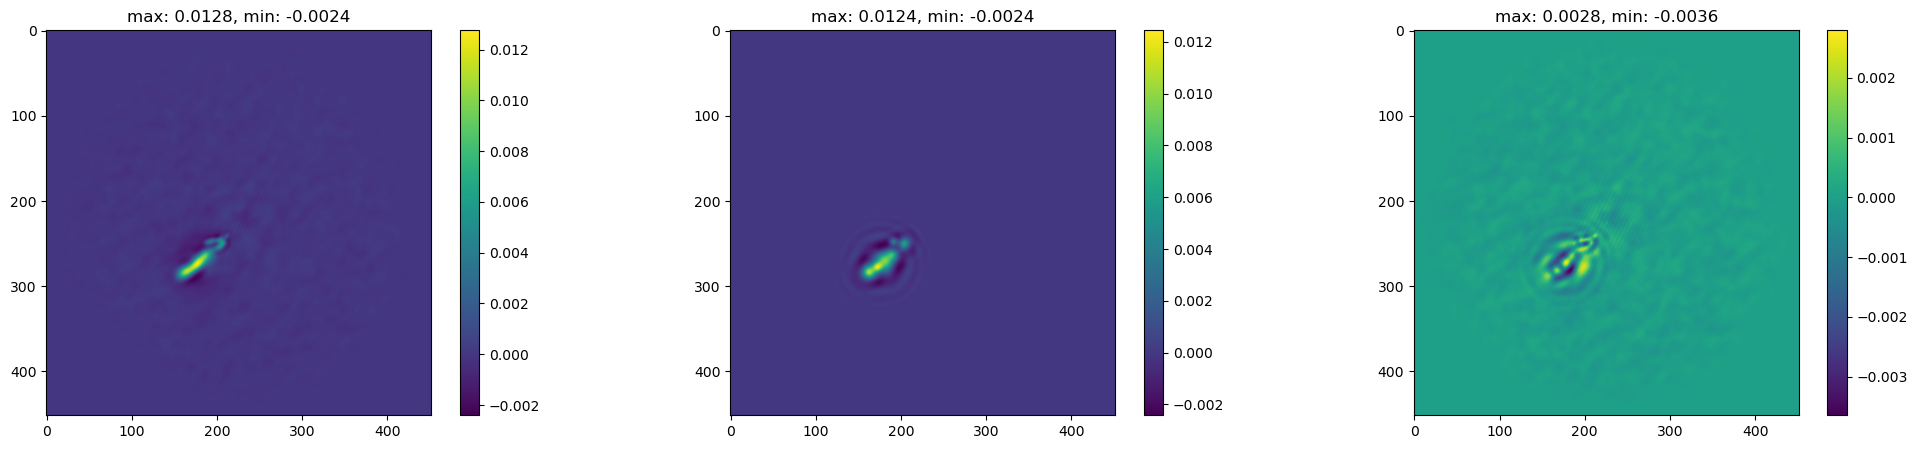

In [10]:
comps, residual, clean, params = CLEAN(data, gain=1, thresh=threshold_otsu(data), niter=50, window=10)
# переделать КЛИН без этих баунс!!!!!!!!!!!!!!!!

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data), ax=ax) 
fig.colorbar(ax2.imshow(clean), ax=ax2) 
fig.colorbar(ax3.imshow(residual), ax=ax3) 
ax.set_title(f'max: {np.max(data):.4f}, min: {np.min(data):.4f}') 
ax2.set_title(f'max: {np.max(clean):.4f}, min: {np.min(clean):.4f}') 
ax3.set_title(f'max: {np.max(residual):.4f}, min: {np.min(residual):.4f}')

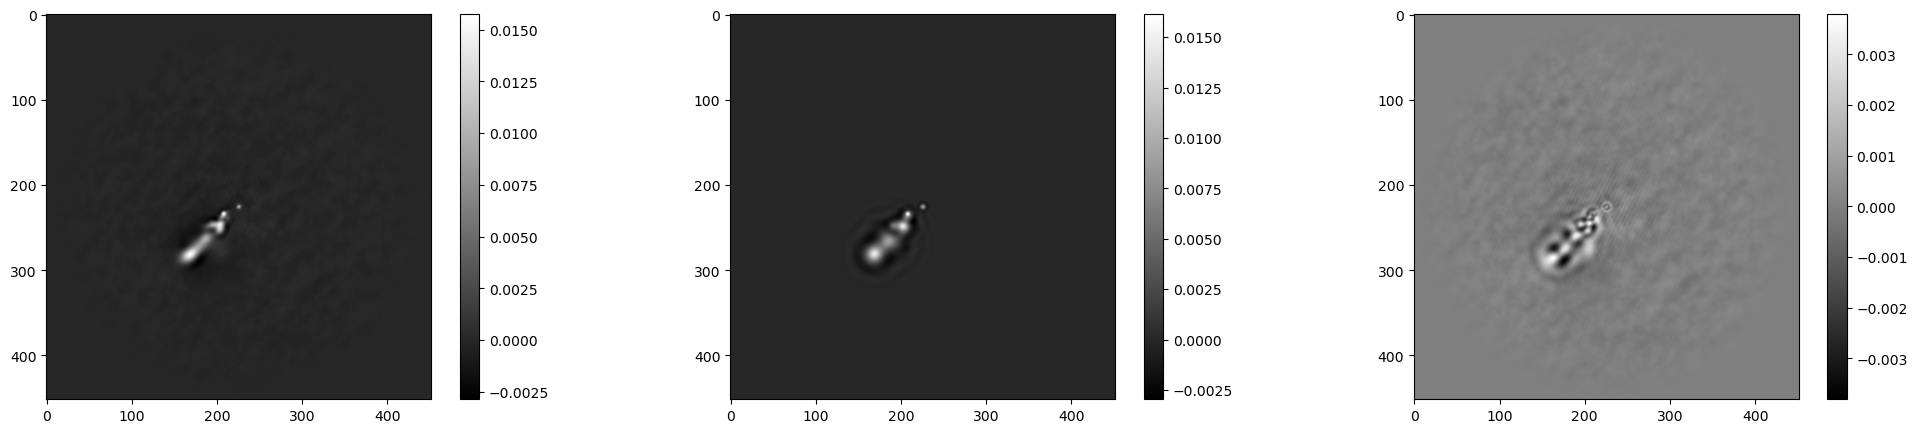

In [7]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 
fig.colorbar(ax.imshow(data, cmap='gray'), ax=ax) 
fig.colorbar(ax2.imshow(clean, cmap='gray'), ax=ax2) 
fig.colorbar(ax3.imshow(residual, cmap='gray'), ax=ax3) 

fig.savefig('D:/astro/clean4_0km.png', bbox_inches='tight')

Cn2: 2.639160110600651e-13
0.5654017150199393


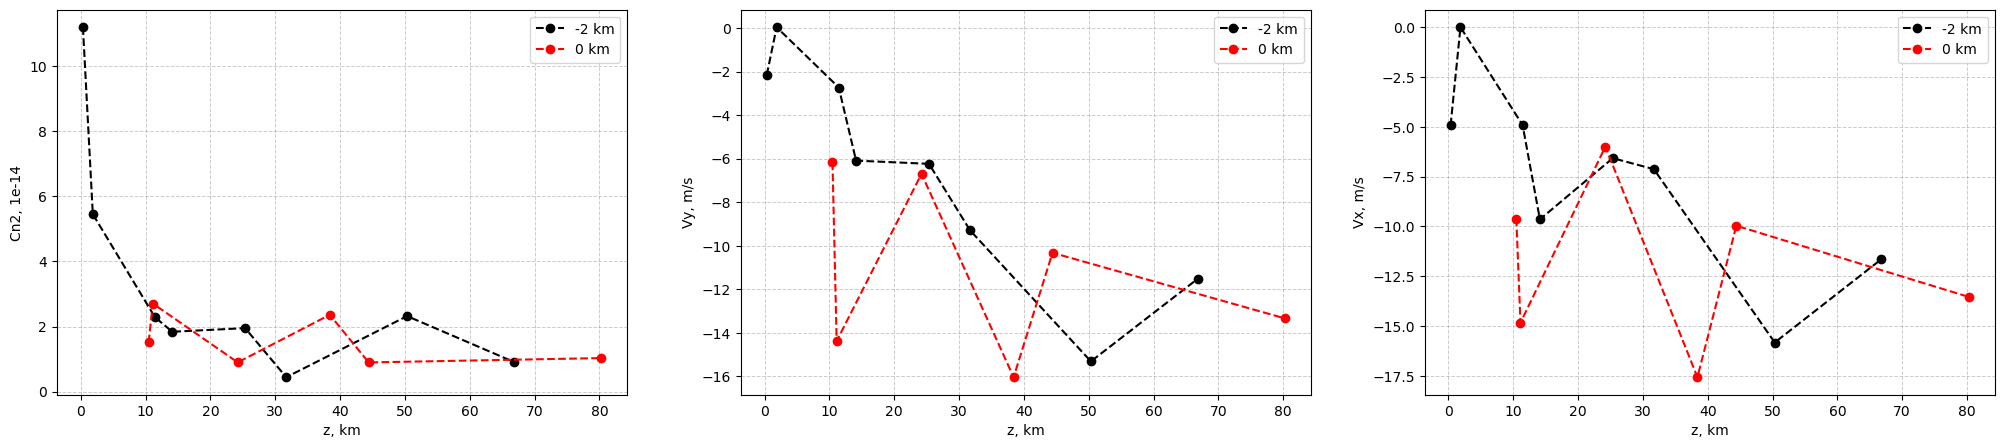

In [16]:
import pandas as pd

df2 = pd.DataFrame(params, columns = ['Vx','Vy','Cn2', 'z'])
df2 = df2.sort_values(by=['z'])

# df = pd.DataFrame(params, columns = ['Vx','Vy','Cn2', 'z'])
# df = df.sort_values(by=['z'])
# df['z'] -= 2
# print(df)

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5)) 

ax.plot(df['z'], df['Cn2'], 'o--', color='black', label='-2 km')
ax2.plot(df['z'], df['Vy'], 'o--', color='black', label='-2 km')
ax3.plot(df['z'], df['Vx'], 'o--', color='black', label='-2 km')

ax.plot(df2['z'], df2['Cn2'], 'o--', color='red', label='0 km')
ax2.plot(df2['z'], df2['Vy'], 'o--', color='red', label='0 km')
ax3.plot(df2['z'], df2['Vx'], 'o--', color='red', label='0 km')

ax.legend()
ax2.legend()
ax3.legend()

ax.set_ylabel('Cn2, 1e-14')
ax.set_xlabel('z, km')
ax2.set_ylabel('Vy, m/s')
ax2.set_xlabel('z, km')
ax3.set_ylabel('Vx, m/s')
ax3.set_xlabel('z, km')

ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
ax3.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

sum_cn2 = np.sum(df['Cn2'])*1e-14
print('Cn2:', sum_cn2)
lambda_ = 500 * pow(10, -9)
r0 = pow(0.423 * pow((2*np.pi/lambda_), 2) * sum_cn2, -3/5)
seeing = 206265 * 0.98 * lambda_/r0
print(seeing)

fig.savefig('D:/astro/profile.png', bbox_inches='tight')

In [26]:
k_height= 20
k_width= 20
R1=np.zeros((k_height, k_width))
R2=np.zeros((k_height, k_width))
h = np.linspace(0, 10, k_height)
c = np.geomspace(1, 1000, k_width)
for i in range(k_height):
    for j in range(k_width):
        R1[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2))
        R2[i, j] = np.sum(pow(data - gamma_poly_se(X, Y, 0, 0, c[j], h[i]), 2)[216:236, 216:236])

print('done')

#двумерная карта невязки, где по осям ОУ размечено разбиение по высотам, а по ОХ - разбиение по мощности. в каждой ячейке
# матрицы содержится значение R = sum(data-model)^2. Видно, что при меньшем окне при подсчете суммы, невязка принимает
# правильное значение минимума. В то время как при подсчете в полном окне, минимум явно не прослеживается и поэтому 
# минимизация выдает такое значение

done


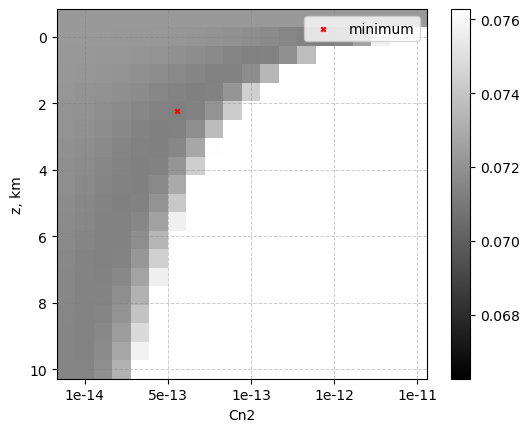

In [28]:
plt.figure()
plt.imshow(R1, vmin=R1[np.unravel_index(np.argmin(R1), R1.shape)]-0.005, 
                       vmax=R1[np.unravel_index(np.argmin(R1), R1.shape)]+0.005, cmap='gray')
plt.colorbar()

plt.scatter(np.unravel_index(np.argmin(R1), R1.shape)[1], np.unravel_index(np.argmin(R1), R1.shape)[0], color='red', s=10, 
            marker='x', label='minimum')

plt.xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-13', '1e-13', '1e-12', '1e-11'])
plt.yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
plt.xlabel('Cn2')
plt.ylabel('z, km')
plt.legend()
plt.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

plt.savefig('D:/astro/R.png', bbox_inches='tight')

blur
0.04547675068231148
3.6362561781154096e-05
full: 0.5263157894736842 6.158482110660264
windowed: 0.0 1.0


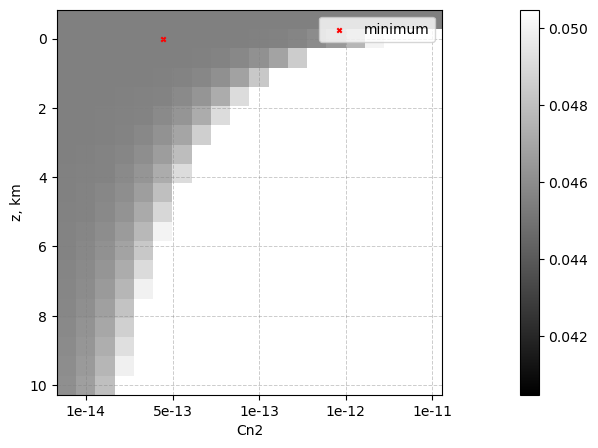

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5)) 
fig.colorbar(ax.imshow(R1, vmin=R1[np.unravel_index(np.argmin(R1), R1.shape)]-0.005, 
                       vmax=R1[np.unravel_index(np.argmin(R1), R1.shape)]+0.005, cmap='gray'), ax=ax)
# fig.colorbar(ax2.imshow(R2, vmin=0,
#                         vmax=0.001, cmap='gray'), ax=ax2)

ax.scatter(np.unravel_index(np.argmin(R1), R1.shape)[1], np.unravel_index(np.argmin(R1), R1.shape)[0], color='red', s=10, 
            marker='x', label='minimum')
# ax2.scatter(np.unravel_index(np.argmin(R2), R2.shape)[1], np.unravel_index(np.argmin(R2), R2.shape)[0], color='red', s=10, 
#             marker='x', label='minimum')

ax.set_xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-13', '1e-13', '1e-12', '1e-11'])
ax.set_yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
ax.set_xlabel('Cn2')
ax.set_ylabel('z, km')
ax.legend()
ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

# ax2.set_xticks (ticks=np.linspace(0+1, k_width-1, 5), labels=['1e-14', '5e-13', '1e-13', '1e-12', '1e-11'])
# ax2.set_yticks (ticks=np.linspace(0+1, k_height-1, 6), labels=['0', '2', '4', '6', '8', '10'])
# ax2.set_xlabel('Cn2')
# ax2.set_ylabel('z, km')
# ax2.legend()
# ax2.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)

# fig.savefig(f'D:/astro/R_{gammas_type}.png', bbox_inches='tight')

# ax.set_title('full')
# ax2.set_title('windowed')

print(gammas_type)
print(R1[np.unravel_index(np.argmin(R1), R1.shape)])
print(R2[np.unravel_index(np.argmin(R2), R2.shape)])
print('full:', h[np.unravel_index(np.argmin(R1), R1.shape)[0]], c[np.unravel_index(np.argmin(R1), R1.shape)[1]])
print('windowed:', h[np.unravel_index(np.argmin(R2), R2.shape)[0]], c[np.unravel_index(np.argmin(R2), R2.shape)[1]])